# Feature optimization

In the following cells, we import the necessary modules and load the train and testset

In [5]:
from ase.io import read, write
import numpy as np
import time
from sklearn.linear_model import Ridge
from rascal.representations import SphericalInvariants as SOAP
from rascal.utils import get_optimal_radial_basis_hypers
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from feature_skcosmo import atom_groups_by_frame
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error
from skopt import callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from sklearn.pipeline import Pipeline


#importing some speed up helpers
from helpers import get_features_in_parallel, get_optimal_radial_basis_hypers_parallel

In [6]:
#loading a subset of the CSD-NMR dataset


train_structures = read("CSD-train.xyz",index=":",format="extxyz")
test_structures = read("CSD-test.xyz",index=":",format="extxyz")

#only build a model for 13C-NMR shifts
for frame in [*train_structures,*test_structures]: mask_center_atoms_by_species(frame,species_select=[6])
for frame in [*train_structures,*test_structures]: frame.wrap(eps=1e-10)
y_train = np.concatenate([frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]]for frame in train_structures])
y_test = np.concatenate([frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]]for frame in test_structures])

#obtain structure groups for group-wise CV
atom_groups = atom_groups_by_frame(train_structures)

#use radial spectrum features to restrict memory and computational demand
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4.5,
              max_radial=5,
              max_angular=5,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              cutoff_function_type="RadialScaling",
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              cutoff_function_parameters= dict(rate=1,
                    scale=2.0,
                    exponent=3
                        ),
              compute_gradients=False,
              expansion_by_species_method="user defined",
              global_species=[1, 6, 7, 8, 16]
              )


print("using {} structures".format(len(train_structures)))
print("{} atomic environments".format(y_train.shape[0]))

using 444 structures
13442 atomic environments


### We continue to build a custom objective

We first will de

In [50]:
#define the searchspace
space = [Real(10**-6, 10**-1, "log-uniform", name='alpha'),
        Real(1.,3.0, "uniform", name="scale"),
        Real(3.0,7.0, "uniform", name="interaction_cutoff"),
        Real(0.05,0.5, "uniform", name="gaussian_sigma_constant"),
        Real(0.1,20., "uniform", name="exponent"),
        Real(0.1,20., "uniform", name="rate")
        ]

In [54]:
feature_gen_time = 0
hyper_opt_time = 0
model_fit_time = 0

@use_named_args(space)
def soap_objective(**params):
    random_state = np.random.RandomState(0)
    global feature_gen_time
    global hyper_opt_time
    global model_fit_time
    
    new_params = params.copy()
    new_hypers = hypers.copy()
    
    
    new_hypers["interaction_cutoff"] = new_params["interaction_cutoff"]
    new_hypers["gaussian_sigma_constant"] = new_params["gaussian_sigma_constant"]
    new_hypers["cutoff_function_parameters"] = {"rate":new_params["rate"],
                                               "exponent":new_params["exponent"],
                                               "scale":new_params["scale"]}
    
    start_time = time.time()
    new_hypers = get_optimal_radial_basis_hypers_parallel(new_hypers,train_structures,expanded_max_radial=20)
    #new_hypers = get_optimal_radial_basis_hypers_parallel(new_hypers, train_structures, blocksize=5, expanded_max_radial=20)
    hyper_opt_time += time.time() - start_time
    
    
    model.set_params(alpha=new_params["alpha"])

    start_time = time.time()
    #representation = SOAP(**new_hypers)
    #X_train = representation.transform(train_structures).get_features(representation)
    X_train = get_features_in_parallel(train_structures,SOAP,new_hypers)
    feature_gen_time += time.time() - start_time
    
    start_time = time.time()
    #in production it might make sense to increase the k-fold to 5, given that bayes opt makes the noise free asummption
    splits = list(GroupKFold(n_splits=3).split(X_train,y_train,groups=atom_groups))
    score = -np.mean(cross_val_score(model, X_train, y_train, cv=splits, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))
    model_fit_time += time.time() - start_time
    print("--eval--")
    return score


In [73]:
model = Ridge()

# We provide a reasonable first guess.
# Parameters reported in 10.1039/C9CP04489B Engel et al.  
# model alpha, scale, cutoff, sigma, exponent, rate
reasonable_guess = [1e-05,2.0,4.5,0.3,3,1]

checkpoint_saver = CheckpointSaver("./checkpoint_solver.pkl", compress=9)

print("starting")
start_time_total = time.time()

# provide search space, number of total objective function calls, a sead, an initial guess (optional)
# the number of jobs to optimize the aquisition function (LBFGS) and a callback (checkpoint saver)
res_gp = gp_minimize(soap_objective, space, n_calls=25, random_state=0, x0=reasonable_guess, n_jobs=-1, callback=[checkpoint_saver])

print("--- 25 steps took %s seconds ---" % (time.time() - start_time_total))
print("--- feature generation took %s seconds ---" % (feature_gen_time))
print("--- model fitting took %s seconds ---" % (model_fit_time))
print("--- hyper optimization took %s seconds ---" % (hyper_opt_time))

dump(res_gp, "solver_final.pkl")

print("finished")

starting
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--eval--
--- 25 steps took 366.0116500854492 seconds ---
--- feature generation took 374.8042507171631 seconds ---
--- model fitting took 660.0854134559631 seconds ---
--- hyper optimization took 430.22706937789917 seconds ---
finished


### Skopt provides nice helper functions to analyze the convergence and results

In [74]:
from skopt.plots import plot_convergence, plot_objective

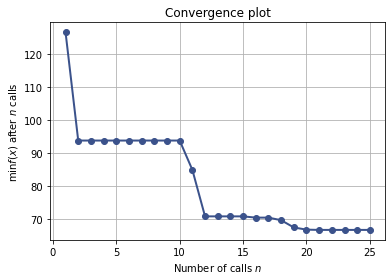

In [75]:
# uses the OptimizeResult object returned from gp_minimize
_ = plot_convergence(res_gp)

In [36]:
#we can also load the last OptimizeResult
res_gp = load("checkpoint_solver.pkl")

### Final and optimized hyperparameters

In [76]:
res_gp.x

[0.005351748983777069,
 2.2303983151034843,
 4.124233562995925,
 0.16202296046236847,
 13.774379713918043,
 13.475528279569906]

# Model optimization

In [77]:
from skopt import BayesSearchCV

In [78]:
optimal_hypers = hypers.copy()
# model alpha, scale, cutoff, sigma, exponent, rate
optimal_hypers["interaction_cutoff"] = res_gp.x[2]
optimal_hypers["gaussian_sigma_constant"] = res_gp.x[3]
optimal_hypers["cutoff_function_parameters"] = {"rate":res_gp.x[5],
                                               "exponent":res_gp.x[4],
                                               "scale":res_gp.x[1]}

optimal_hypers = get_optimal_radial_basis_hypers(optimal_hypers, train_structures, expanded_max_radial=20)

In [79]:
representation = SOAP(**optimal_hypers)
Xtrain = representation.transform(train_structures).get_features(representation)
Xtest = representation.transform(test_structures).get_features(representation)


In [67]:
#from sklearn.kernel_ridge import KernelRidge
#from sklearn.kernel_approximation import Nystroem
#NystroemKRR = Pipeline([("map",Nystroem(n_components=1000,n_jobs=4)),("model",Ridge())])
#model_space = {"map__gamma":Real(10**-6, 10**1, "log-uniform"),"model__alpha": Real(10**-6, 10**1, "log-uniform")}

In [80]:
model_space = {"alpha":Real(10**-8, 10**1, "log-uniform")}

clf_bayes = BayesSearchCV(Ridge(),n_iter=15,search_spaces=model_space,scoring="neg_mean_squared_error",cv=GroupKFold(n_splits=5),random_state=0,verbose=1)

In [81]:
clf_bayes.fit(Xtrain,y_train,groups=atom_groups)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=GroupKFold(n_splits=5), estimator=Ridge(), n_iter=15,
              random_state=0, scoring='neg_mean_squared_error',
              search_spaces={'alpha': Real(low=1e-08, high=10, prior='log-uniform', transform='normalize')},
              verbose=1)

In [82]:
clf_bayes.best_params_["alpha"]

0.0013862442939700352

In [83]:
y_test_predict = clf_bayes.predict(Xtest)

In [84]:
mean_squared_error(y_test_predict,y_test,squared=False)

5.591320157869809

### We can again take a look at the convergence (not great)

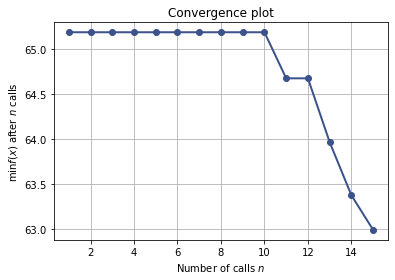

In [85]:
_ = plot_convergence(clf_bayes.optimizer_results_[0])